<H3> Astrometry quality checks </H3>

The idea is to compute the distribution of the angular distances between matched sources from a set of exposures covering the same area. We arbitrarily take the first exposure as a reference.

The angular distance is computed:
<OL>
<LI> using the source coordinates associated to the "src" catalog, thus corresponding to the standard astrometric solution (fit using an external reference catalog only)</LI>
<LI> using the updated WCS from the simultaneous astrometry fit</LI>
</OL>

In [14]:
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import numpy as np
import math

# List of visits to be considered
#visits = [7274, 7276, 7420, 7422, 14108, 14112, 38074, 38080]
visits = [7274, 7276, 7420, 7422, 14108]

# Reference visit
ref = 7274

# Tract
tract = 0

# List of CCD to be considered (source calatlogs will be concateneted)
#ccd = [12, 13, 14, 21, 22, 23]
# Number of CCD (max=104)
nCcd = 30
ccd = range(nCcd)

filter = 'HSC-I'

fluxType = "base_PsfFlux"

Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         "base_PsfFlux_flag_edge", fluxType + "_flag", "base_SdssCentroid_flag", 
         "base_SdssShape_flag"]

#setup butler - Replace path name by something suitable for you
butler = dafPersist.Butler("/sps/lsst/dev/lsstprod/hsc/SXDS/output")
 
# Initialize empty list to record calibration and WSC objects    
calibRef = [None]*nCcd
oldWcsRef = [None]*nCcd
newWcsRef = [None]*nCcd

for indx, c in enumerate(ccd) :
    # reject bad CCD
    if c == 9:
        continue
        
    dataid = {'visit':ref, 'filter':filter, 'ccd':c}
    oldSrc = butler.get('src', dataid, immediate=True)
    print(c, len(oldSrc))
    if indx == 0 :
        # retrieve the schema of the source catalog and extend it in order to add a field to record 
        # the ccd number
        oldSchema = oldSrc.getSchema()
        mapper = afwTable.SchemaMapper(oldSchema)
        mapper.addMinimalSchema(oldSchema)
        newSchema = mapper.getOutputSchema()
        newSchema.addField("ccd", type=np.int32, doc="CCD number")

        #create the new extented source catalog 
        srcRef = afwTable.SourceCatalog(newSchema)
        srcRef.reserve(5000000)

    # create temporary catalog
    tmpCat = afwTable.SourceCatalog(srcRef.table)
    tmpCat.extend(oldSrc, mapper=mapper)
    # fill in the ccd information in numpy mode in order to be efficient
    tmpCat['ccd'][:] = c
    # append the temporary catalog to the extended source catalog    
    srcRef.extend(tmpCat, deep=False)
        
    # retrieve the calibration object associated to the CCDs
    mdRef = butler.get("calexp_md", dataid, immediate=True)
    calibRef[c] =afwImage.Calib(mdRef)
        
    # retrieve the original and improved wcs
    oldWcsRef[c] = afwImage.makeWcs(mdRef)
    dataidNew = {'visit':ref, 'filter':filter, 'ccd':c, 'tract':tract}
    newWcsRefCont = butler.get('wcs', dataidNew, immediate=True)
    newWcsRef[c] = newWcsRefCont.getWcs()

print("Ref...", len(srcRef))

0 1007
1 1400
2 1377
3 1135
4 935
5 1275
6 1410
7 1505
8 1304
10 1379
11 1367
12 1418
13 1337
14 1253
15 1243
16 1265
17 1502
18 1378
19 1582
20 1196
21 1118
22 1510
23 1332
24 1534
25 1470
26 1426
27 1502
28 1370
29 1464
Ref... 38994


In [15]:
# Store original and updated Wcs associated to each visit / ccd
oldWcsVis = {}
newWcsVis = {}
for v in visits :
    oldWcsVis[v] = [None]*nCcd
    newWcsVis[v] = [None]*nCcd

    for c in ccd :
        # skip some bad CCDs
        if c == 9:
            continue
        if v == 38074 and c == 77:
            continue
        dataid = {'visit':v, 'filter':filter, 'ccd':c}
        dataidNew = {'visit':v, 'filter':filter, 'ccd':c, 'tract':tract}
        mdVis = butler.get("calexp_md", dataid, immediate=True)
        oldWcsVis[v][c] = afwImage.makeWcs(mdVis)
        newWcsVisCont = butler.get('wcs', dataidNew, immediate=True)
        newWcsVis[v][c] = newWcsVisCont.getWcs()

In [16]:
newWcsVis

{7274: [<lsst.afw.image.tanWcs.TanWcs at 0x7f3aa4ec6880>,
  None,
 7276: [<lsst.afw.image.tanWcs.TanWcs at 0x7f39e645b148>,
  None,
 7420: [<lsst.afw.image.tanWcs.TanWcs at 0x7f39e645b9d0>,
  None,
 7422: [<lsst.afw.image.tanWcs.TanWcs at 0x7f39e646f538>,
  None,
 14108: [<lsst.afw.image.tanWcs.TanWcs at 0x7f39e6470490>,
  None,
  <lsst.afw.image.tanWcs.TanWcs at 0x7f38ebec4490>]}

In [17]:
#Initialize some lists        
mag = []
oldDist = []
newDist = []

xSig = []
ff = 0
for indV, v in enumerate(visits) :
    if v == ref :
        continue
    print("Visit:", v)
    if ff == 0 :
        ff = 1
    for indC, c in enumerate(ccd) :
        if c == 9:
            continue
        if v == 38074 and c == 77:
            continue
        dataid = {'visit':v, 'filter':filter, 'ccd':c}
        src = butler.get('src', dataid, immediate=True)
        
        # match current source catalog with the reference catalog 
        match = afwTable.matchRaDec(srcRef, src, afwGeom.Angle(1./3600., afwGeom.degrees))

        schemaRef = srcRef.getSchema()
        if ff == 1 and indC == 0 :
            ff = 2
            schemaSrc = src.getSchema()
            flagKeyRef = []
            flagKeyVis = []
            for f in Flags :
                keyRef = schemaRef[f].asKey()
                flagKeyRef.append(keyRef)
                keyVis = schemaSrc[f].asKey()
                flagKeyVis.append(keyVis)

            extendKey = newSchema["base_ClassificationExtendedness_value"].asKey()
            fluxKey = newSchema[fluxType + "_flux"].asKey()
            fluxSigmaKey = newSchema[fluxType + "_fluxSigma"].asKey()
            ccdKeyRef = newSchema["ccd"].asKey()
            
            xSigmaKey = schemaSrc["base_SdssCentroid_xSigma"].asKey()
            ySigmaKey = schemaSrc["base_SdssCentroid_ySigma"].asKey()
            mxxKey = schemaSrc["base_SdssShape_xx"].asKey()
            myyKey = schemaSrc["base_SdssShape_yy"].asKey()
            mxyKey = schemaSrc["base_SdssShape_xy"].asKey()              

        for m in match :
            mRef = m.first
            mVis = m.second

            for f in flagKeyRef :
                rej = 0
                if mRef.get(f) :
                    rej = 1
                    break
            if rej == 1 :
                    continue
            for f in flagKeyVis :
                rej = 0
                if mVis.get(f) :
                    rej = 1
                    break
            if rej == 1 :
                    continue
                    
            # cleanup the reference sources in order to keep only decent star-like objects
            if mRef.get(extendKey) >= 0.5 :
                continue

            ang = afwGeom.radToMas(m.distance)

            # retrieve the CCD corresponding to the reference source
            ccdRef = mRef.get(ccdKeyRef)
            ccdVis = c

            # compute magnitude
            calib = calibRef[ccdRef]
            flux = mRef.get(fluxKey)
            fluxSigma = mRef.get(fluxSigmaKey)
            if flux /fluxSigma < 5 :
                continue
            if flux > 0. :
                refMag = calib.getMagnitude(flux)
            else :
                continue
            # Reject source if magnitude is outside HSC range
            if refMag < 16.5 or refMag > 26 :
                continue

            # Reject blended sources
            footprint = mVis.getFootprint()
            if footprint is not None and len(footprint.getPeaks()) > 1 :
                continue
                
            # Check consistency of the source covariance parameters
            vx = np.square(mVis.get(xSigmaKey))
            vy = np.square(mVis.get(ySigmaKey))
            mxx = mVis.get(mxxKey)
            myy = mVis.get(myyKey)
            mxy = mVis.get(mxyKey)
            vxy = mxy*(vx+vy)/(mxx+myy)
            if (vxy*vxy)>(vx*vy) or np.isnan(vx) or np.isnan(vy):
                print("Error in covariance : ", v, c, ccdRef, vxy*vxy, vx*vy, vx, vy, mVis.get("base_SdssCentroid_flag"), mVis.get("base_SdssShape_flag"))
                print(mVis.get(xSigmaKey), mVis.get(ySigmaKey), mxx, myy, mxy)
                print(mVis.get("base_SdssCentroid_x"), mVis.get("base_SdssCentroid_y"))
                continue

            oldCoordRef = mRef.getCoord()
            pixelsRef = oldWcsRef[ccdRef].skyToPixel(oldCoordRef.getRa(), oldCoordRef.getDec())
            newCoordRef = newWcsRef[ccdRef].pixelToSky(pixelsRef).toIcrs()

            oldCoordVis = mVis.getCoord()
            pixelsVis = oldWcsVis[v][c].skyToPixel(oldCoordVis.getRa(), oldCoordVis.getDec())
            newCoordVis = newWcsVis[v][c].pixelToSky(pixelsVis).toIcrs()

            newAngle = 1000.0*newCoordRef.angularSeparation(newCoordVis).asArcseconds()       

            mag.append(refMag)
            oldDist.append(ang)
            newDist.append(newAngle)
            xSig.append(mVis.get(xSigmaKey))

Visit: 7276
Visit: 7420
Visit: 7422
Visit: 14108


### Plot results for the standard astrometric solution (fit source coordinates to an external reference catalog only)

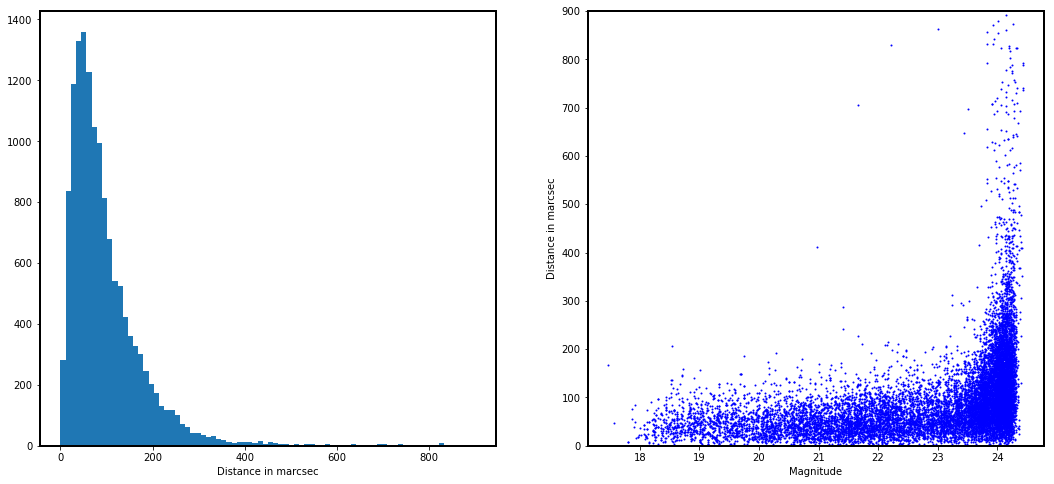

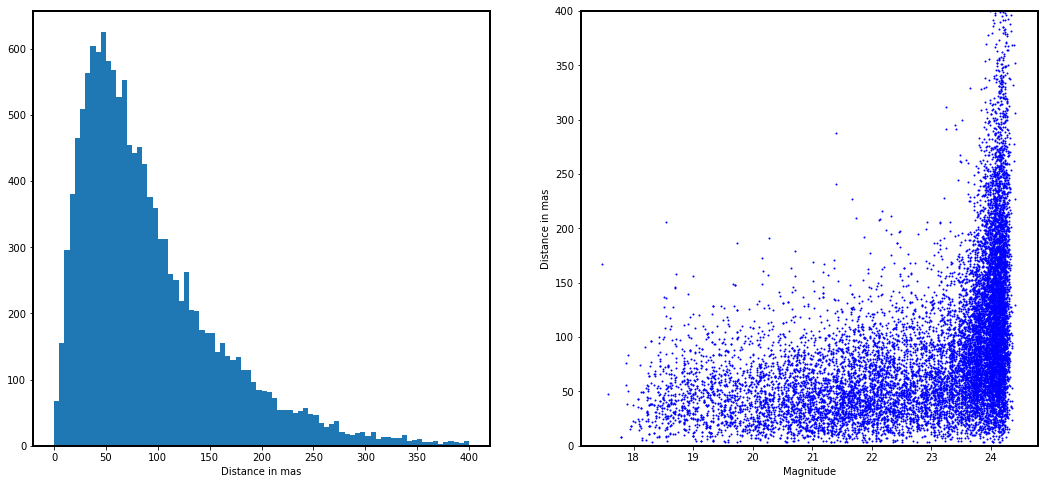

Median value of the astrometric scatter : 75.2871524095 mas


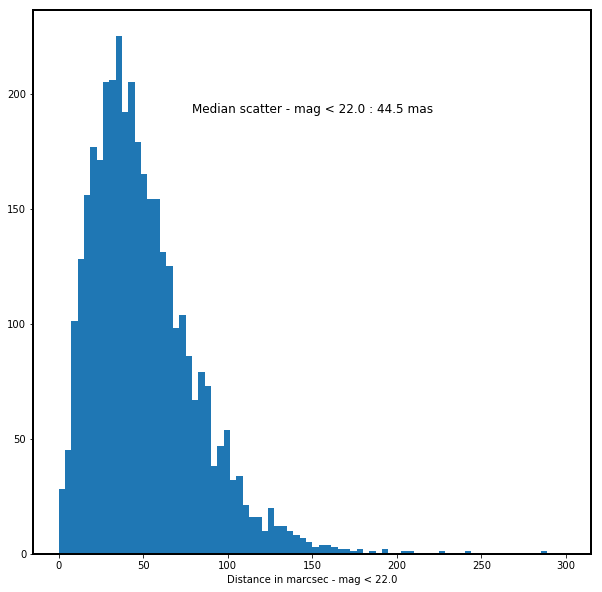

Median scatter - mag < 22.0 : 44.5 mas


In [18]:

%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

# Plot distance between sources in different exposures
plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(oldDist, bins=80, range=[0.,900.])
ax1.scatter(mag, oldDist, s=1, color='b')
ax0.set_xlabel("Distance in marcsec")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in marcsec")
ax1.set_ylim([0., 900.])
plt.show()

plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(oldDist,bins=80, range=[0.,400.])
ax1.scatter(mag, oldDist, s=1, color='b')
ax1.set_ylim([0.,400.])
ax0.set_xlabel("Distance in mas")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in mas")
plt.show()

print("Median value of the astrometric scatter :", np.median(oldDist), "mas")

magLim = 22
idxs = np.where(np.asarray(mag) < magLim)
plt.clf()
fig, ax0 = plt.subplots(ncols=1, figsize=(10,10))
ax0.hist(np.asarray(oldDist)[idxs], bins=80, range=[0., 300.])
ax0.set_xlabel("Distance in marcsec - mag < %0.1f"%(magLim))
ax0.set_title("Median scatter - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(oldDist)[idxs])),x=0.5, y=0.8)
plt.show()

print("Median scatter - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(oldDist)[idxs])))

### Plot results for astrometric solution from the simultaneous fit

Median value of the astrometric scatter : 44.9496031104 mas
Astrometric scatter (median) - mag < 22.0 : 7.2 mas


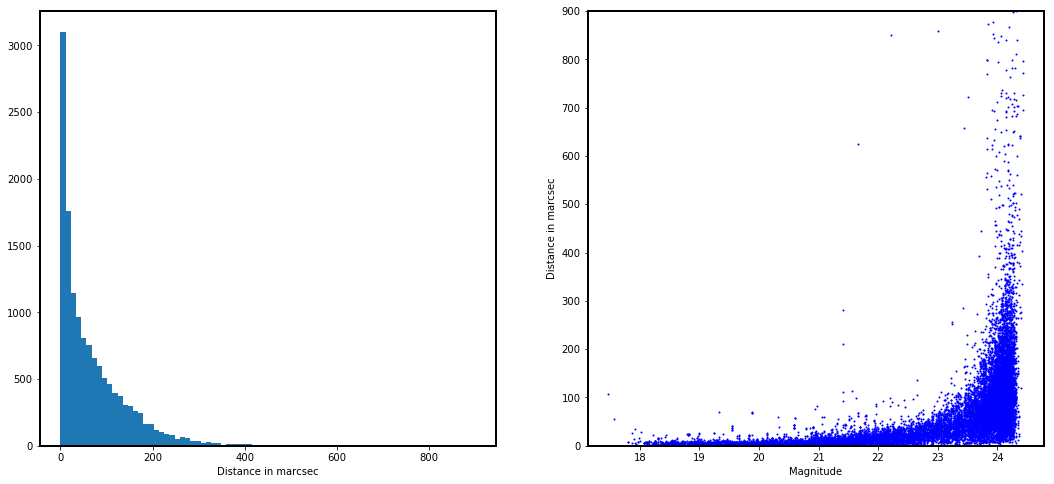

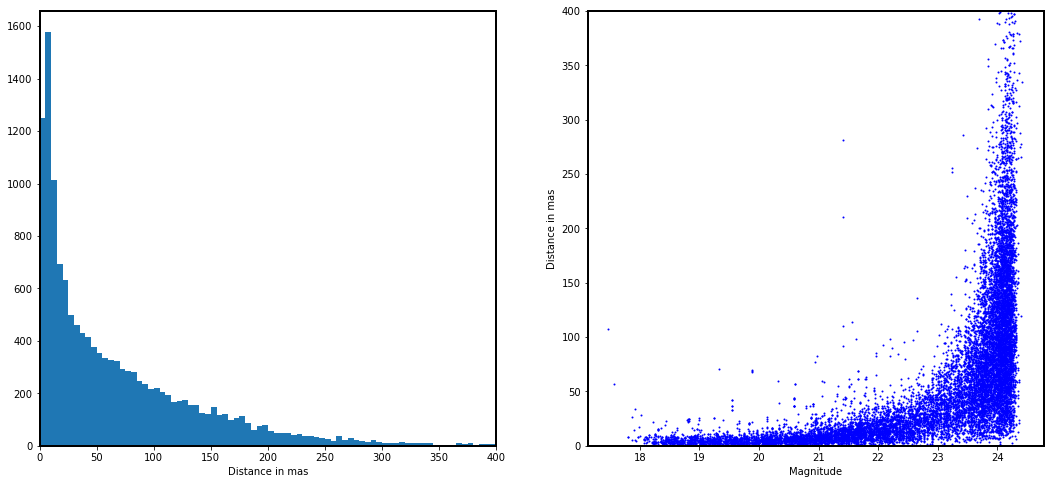

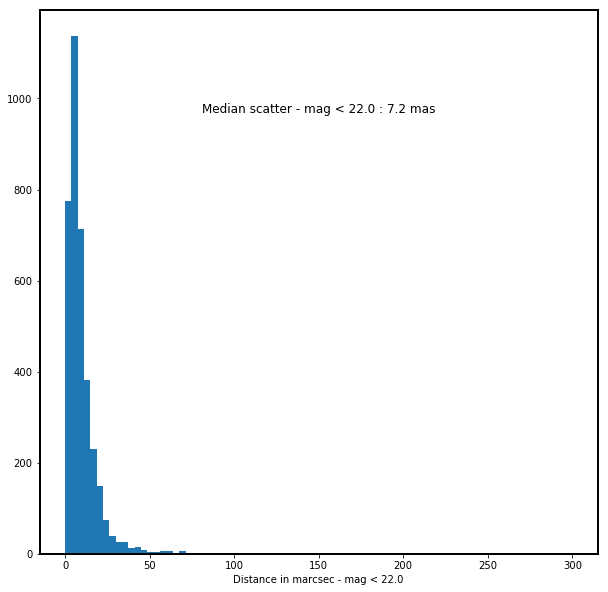

In [19]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

# Plot distance between sources in different exposures
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(newDist, bins=80, range=[0., 900.])
ax1.scatter(mag, newDist, s=1, color='b')
ax0.set_xlabel("Distance in marcsec")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in marcsec")
ax1.set_ylim([0., 900.])

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(newDist,bins=80, range=[0., 400.])
ax0.set_xlim([0.,400.])
ax1.scatter(mag, newDist, s=1, color='b')
ax1.set_ylim([0.,400.])
ax0.set_xlabel("Distance in mas")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in mas")

print("Median value of the astrometric scatter :", np.median(newDist), "mas")

magLim = 22
idxs2 = np.where(np.asarray(mag) < magLim)
fig, ax0 = plt.subplots(ncols=1, figsize=(10,10))
ax0.hist(np.asarray(newDist)[idxs2], bins=80, range=[0., 300.])
ax0.set_xlabel("Distance in marcsec - mag < %0.1f"%(magLim))
ax0.set_title("Median scatter - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(newDist)[idxs2])),x=0.5, y=0.8)

print("Astrometric scatter (median) - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(newDist)[idxs2])))

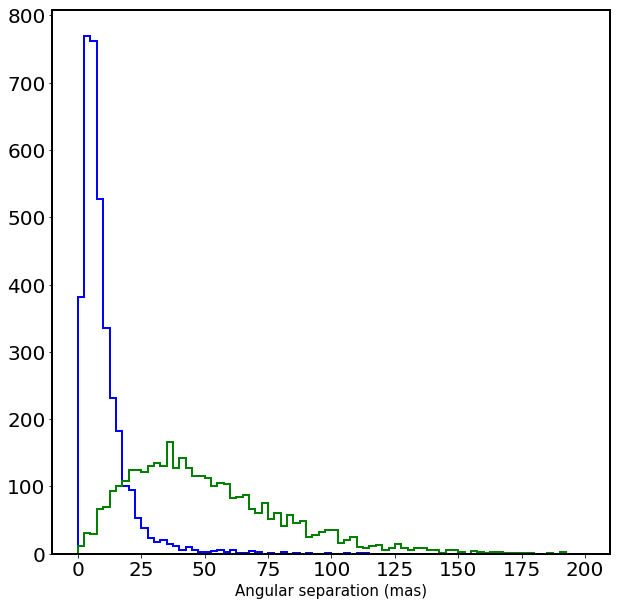

In [20]:
font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 25,
        }

plt.rcParams['axes.linewidth'] = 2 
plt.rcParams['mathtext.default'] = 'regular'

fig, ax0 = plt.subplots(ncols=1, figsize=(10,10))
ax0.hist(np.asarray(newDist)[idxs2], bins=80, range=[0., 200.], color='b', histtype = 'step', lw=2)
ax0.set_xlabel("Angular separation (mas)", fontsize=15)

ax0.hist(np.asarray(oldDist)[idxs2], bins=80, range=[0., 200.], color='g', histtype = 'step', lw=2)
ax0.tick_params(labelsize=20)

#ax0.text(25, 4400, "Median scatter (jointcal) - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(newDist)[idxs2])),
#             fontsize=15, color='b')
#ax0.text(25, 4700, "Median scatter (meas_astrom) - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(oldDist)[idxs])),
#             fontsize=15, color='g')